Trying deepsets method

Setup

In [1]:
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable


from library.datasets import Signal_Images_Dataset, Bootstrapped_Signal_Unbinned_Dataset
from library.nn_training import select_device, train_and_eval, Custom_Model
from library.plotting import plot_loss_curves, setup_high_quality_mpl_params, plot_prediction_linearity, make_plot_note

device = select_device()


Device:  cuda


Model definition

In [2]:
class Res_Block_Event(nn.Module):
    def __init__(self, in_out_features, num_events_per_set):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features=in_out_features, out_features=in_out_features),
            # nn.LayerNorm(normalized_shape=(num_events_per_set, in_out_features)),
            nn.ReLU(),
            nn.Linear(in_features=in_out_features, out_features=in_out_features),
            # nn.LayerNorm(normalized_shape=(num_events_per_set, in_out_features)),
        )
        self.last_activation = nn.ReLU()
    def forward(self, x):
        x = self.block(x) #+ x
        x = self.last_activation(x)
        return x


class Res_Block_Set(nn.Module):
    def __init__(self, in_out_features):
        super().__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features=in_out_features, out_features=in_out_features),
            # nn.BatchNorm1d(num_features=in_out_features),
            nn.ReLU(),
            nn.Linear(in_features=in_out_features, out_features=in_out_features),
            # nn.BatchNorm1d(num_features=in_out_features),
        )
        self.last_activation = nn.ReLU()
    def forward(self, x):
        x = self.block(x) #+ x
        x = self.last_activation(x)
        return x


class Deep_Sets(Custom_Model):
    def __init__(self, nickname, model_dir, num_events_per_set):
        super().__init__(nickname, model_dir)

        self.f = nn.Sequential(
            nn.Linear(in_features=4, out_features=32),
            # nn.LayerNorm(normalized_shape=(num_events_per_set, 32)),
            nn.ReLU(),
            *[Res_Block_Event(in_out_features=32, num_events_per_set=num_events_per_set) for _ in range(3)],
            nn.Linear(in_features=32, out_features=32),
            # nn.LayerNorm(normalized_shape=(num_events_per_set,32)),
        )

        self.g = nn.Sequential(
            *[Res_Block_Set(in_out_features=32) for _ in range(3)],
            nn.Linear(in_features=32, out_features=32),
            # nn.BatchNorm1d(num_features=32), 
            nn.ReLU(),
            nn.Linear(in_features=32, out_features=1),
        )
        
        self.double()

    def forward(self, x):
        x = self.f(x)
        x = torch.mean(x, dim=1)
        x = self.g(x)
        x = torch.squeeze(x)
        return x

Data Loading

In [3]:
regenerate = True

level = "gen"
save_dir = "../../state/new_physics/data/processed"

common_generate_kwargs = {
    "raw_signal_dir": "../../state/new_physics/data/raw/signal",
    "std_scale": True,
    "q_squared_veto": True,
    "balanced_classes": True,
    "num_events_per_set": 70_000,
    "num_sets_per_label": 50,
}

datasets = {
    "train": Bootstrapped_Signal_Unbinned_Dataset(level=level, split="train", save_dir=save_dir),
    "eval": Bootstrapped_Signal_Unbinned_Dataset(level=level, split="eval", save_dir=save_dir),
}

if regenerate:
    datasets["train"].generate(
        raw_trials=range(1,21), 
        **common_generate_kwargs
    )
    datasets["eval"].generate(
        raw_trials=range(21,41), 
        **common_generate_kwargs
    )

datasets["train"].load(device)
datasets["eval"].load(device)

# datasets["train"].features = torch.transpose(datasets["train"].features, dim0=1, dim1=2)
# datasets["eval"].features = torch.transpose(datasets["eval"].features, dim0=1, dim1=2)

# print(f"new train features shape: {datasets["train"].features.shape}")
# print(f"new eval features shape: {datasets["eval"].features.shape}")


opened raw file: [1/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_10_re.pkl
opened raw file: [2/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_11_re.pkl
opened raw file: [3/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_12_re.pkl
opened raw file: [4/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_13_re.pkl
opened raw file: [5/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_14_re.pkl
opened raw file: [6/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_15_re.pkl
opened raw file: [7/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_16_re.pkl
opened raw file: [8/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_17_re.pkl
opened raw file: [9/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_18_re.pkl
opened raw file: [10/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_19_re.pkl
opened raw file: [11/876] ..\..\state\new_physics\data\raw\signal\dc9_-0.01_1_re.pkl
opened raw file: [12/876] ..\..\state\new_physics\data\raw\signa


epoch 0 complete:
    Train loss: 0.9325315063592898
    Eval loss: 0.86382663573178

learning rate: [0.0004]
peak gpu memory usage: 14.07624 GB

epoch 1 complete:
    Train loss: 0.8326590984265791
    Eval loss: 0.8291168172540154

learning rate: [0.0004]
peak gpu memory usage: 14.07624 GB

epoch 2 complete:
    Train loss: 0.8244074433697282
    Eval loss: 0.8245812837284641

learning rate: [0.0004]
peak gpu memory usage: 14.07624 GB

epoch 3 complete:
    Train loss: 0.8234574923027833
    Eval loss: 0.8201355353194443

learning rate: [0.0004]
peak gpu memory usage: 14.07624 GB

epoch 4 complete:
    Train loss: 0.8175534472850166
    Eval loss: 0.8078011353282258

learning rate: [0.0004]
peak gpu memory usage: 14.07624 GB

epoch 5 complete:
    Train loss: 0.800052977669424
    Eval loss: 0.8505848708781182

learning rate: [0.0004]
peak gpu memory usage: 14.07624 GB

epoch 6 complete:
    Train loss: 0.785990722963837
    Eval loss: 0.7516509984608027

learning rate: [0.0004]
pea

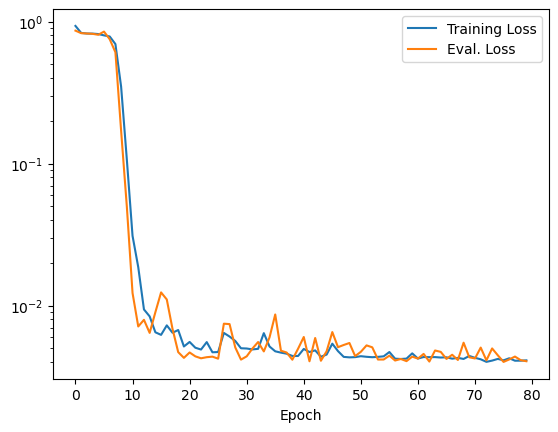

In [4]:
retrain = True

nickname = "deepsets_6k"

model = Deep_Sets(nickname, "../../state/new_physics/models", num_events_per_set=common_generate_kwargs["num_events_per_set"])

if retrain:
    learning_rate = 4e-4
    epochs = 80
    train_batch_size = 32
    eval_batch_size = 32
    loss_fn = nn.MSELoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_and_eval(
        model, 
        datasets["train"], datasets["eval"], 
        loss_fn, optimizer, 
        epochs, 
        train_batch_size, eval_batch_size, 
        device, 
        move_data=False,
        scheduler=ReduceLROnPlateau(optimizer, factor=0.9, patience=1),
        checkpoint_epochs=5,
    )
    _, ax = plt.subplots()
    plot_epoch_start = 0
    plot_loss_curves(
        model.loss_table["epoch"][plot_epoch_start:], 
        model.loss_table["train_loss"][plot_epoch_start:], 
        model.loss_table["eval_loss"][plot_epoch_start:], 
        ax
    )
    ax.set_yscale("log")
    plt.show()
else:
    pass
    # model.load_final()
    # model.load_checkpoint(epoch_number=10)
    # model.to(device)

Evaluate model (validation dataset)

Final: 


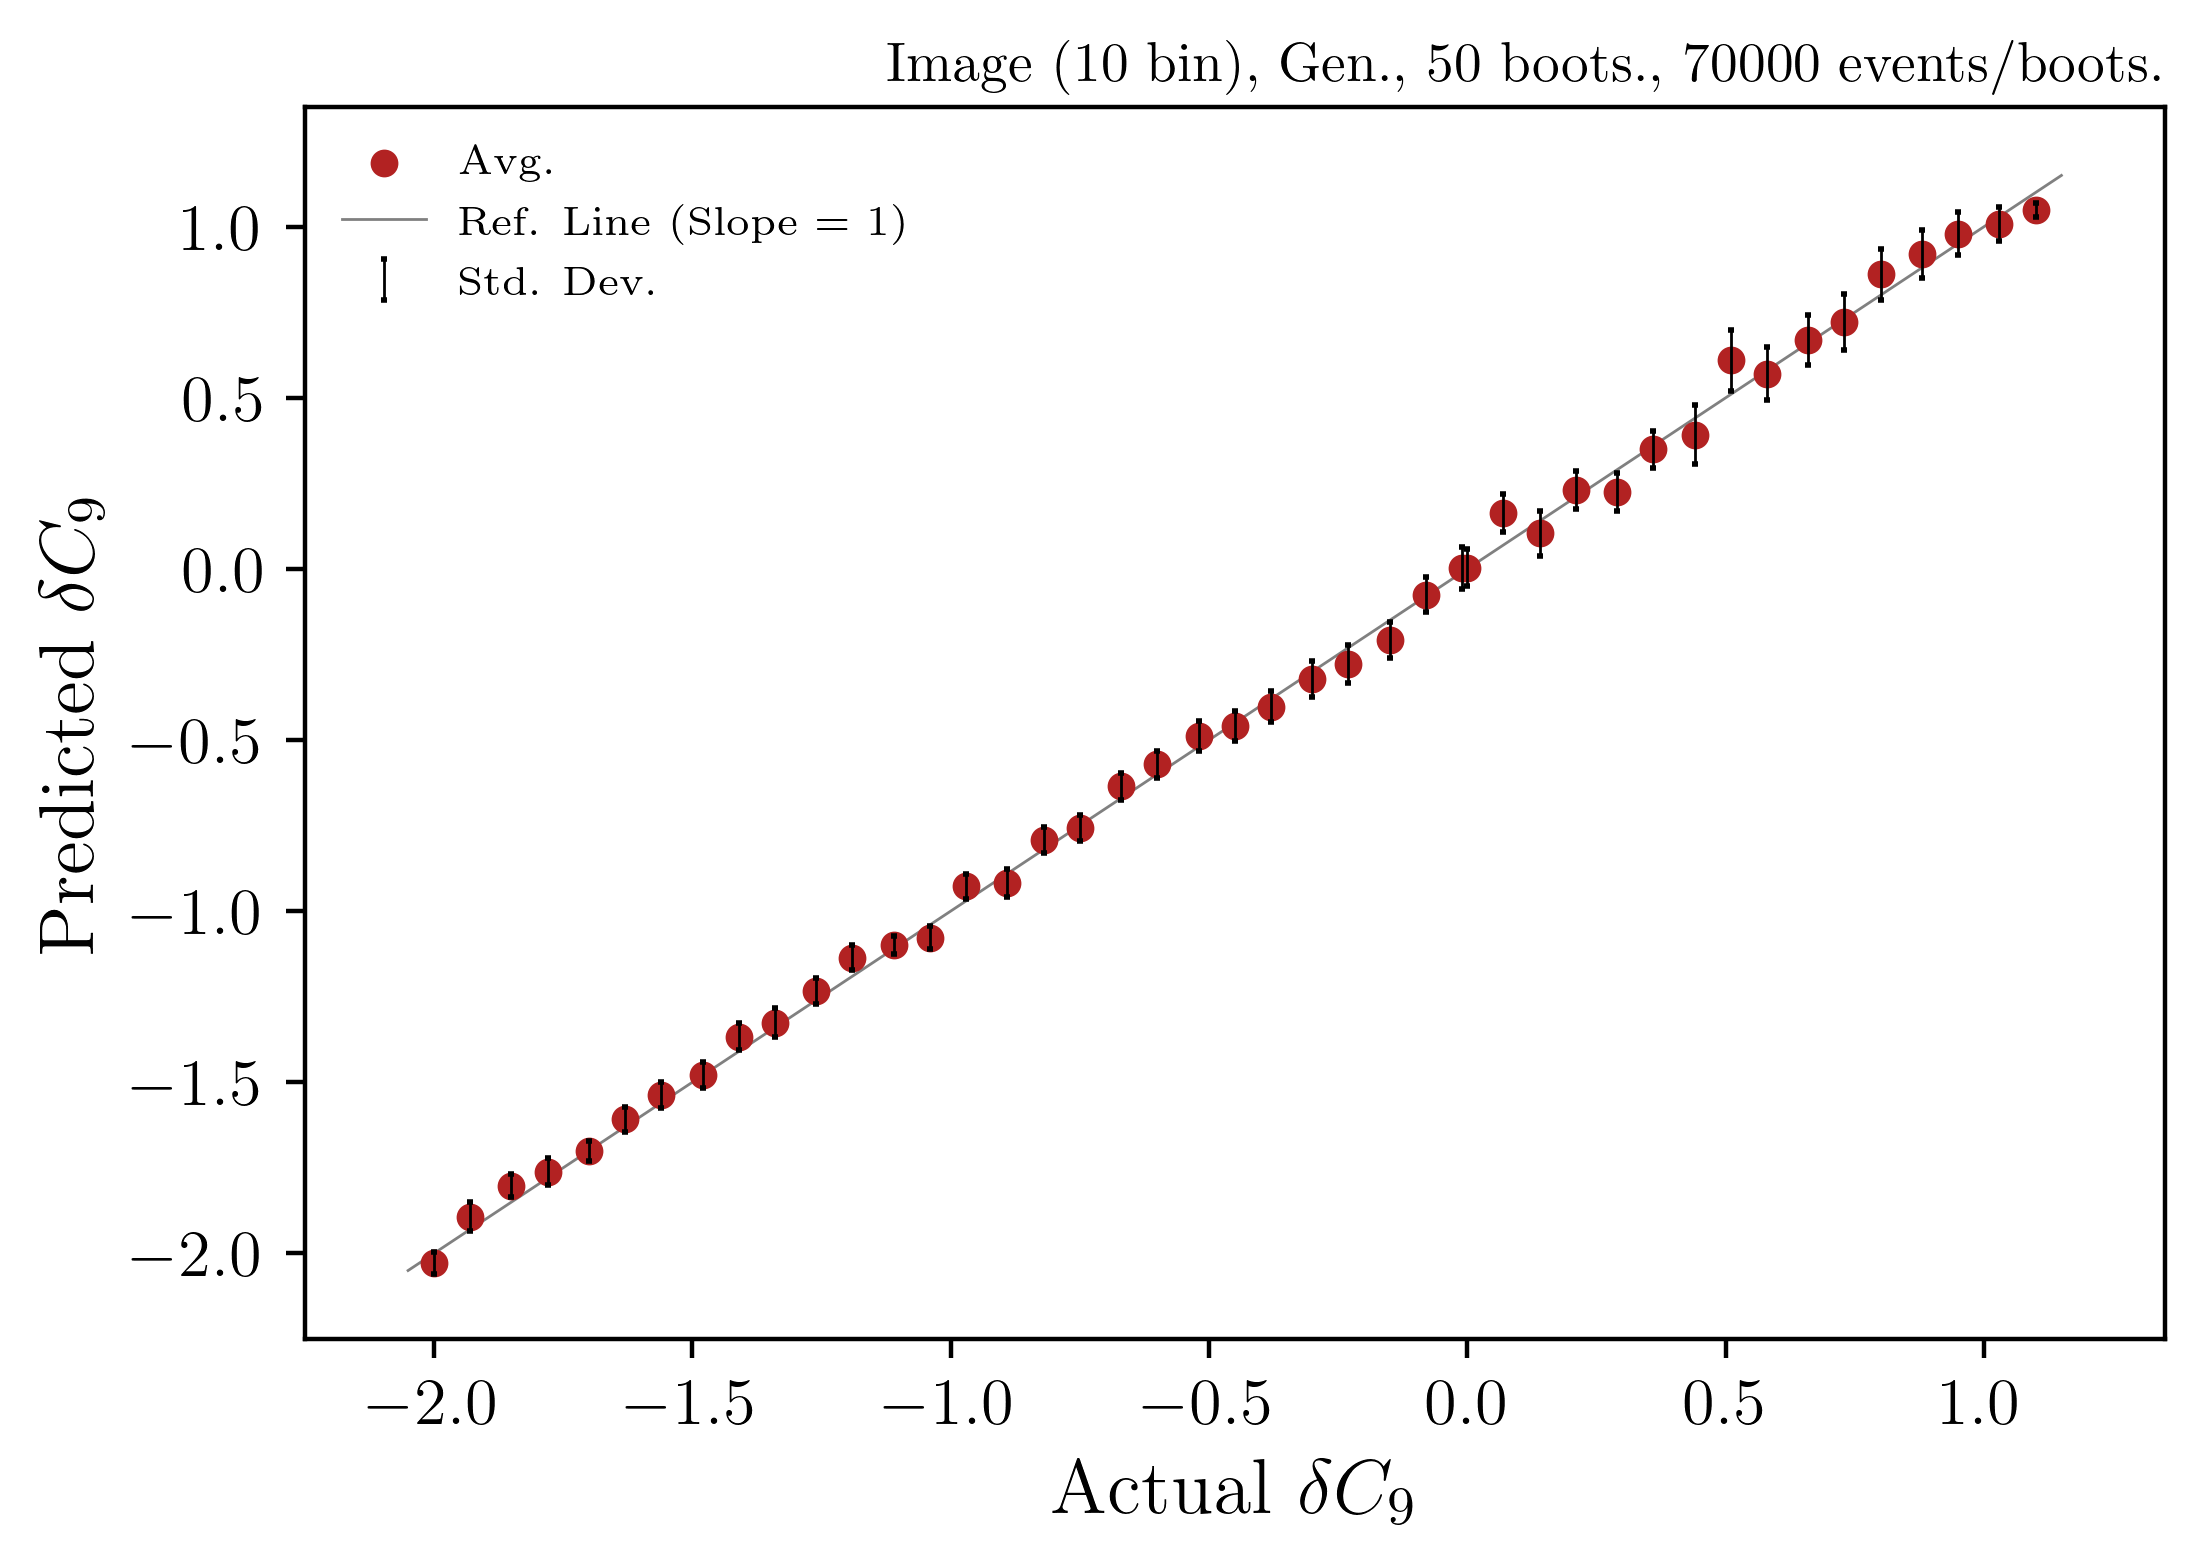

In [5]:
# model = Deep_Sets(nickname, "../../state/new_physics/models", num_events_per_set=common_generate_kwargs["num_events_per_set"])

# for ep in range(0, 80, 5):
#     model.load_checkpoint(epoch_number=ep)
#     model.to(device)

#     model.eval()
#     with torch.no_grad():
        
#         yhat = model(datasets["eval"].features)
#         avgs = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
#         stds = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).std(1).detach().cpu().numpy()

#         y = datasets["eval"].labels
#         unique_y = y.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
#         unique_y

#         fig, ax = plt.subplots()
#         plot_prediction_linearity(ax, unique_y, avgs, stds)
#         plt.show()
#         plt.close()


print("Final: ")

setup_high_quality_mpl_params()

model.load_final()
model.to(device)

model.eval()
with torch.no_grad():
    
    yhats = []
    for feat in datasets["eval"].features:
        feat = feat.unsqueeze(0)
        yhat = model(feat)
        yhats.append(yhat)

    yhats = torch.tensor(yhats)
    avgs = yhats.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    stds = yhats.reshape(-1, common_generate_kwargs["num_sets_per_label"]).std(1).detach().cpu().numpy()

    y = datasets["eval"].labels
    unique_y = y.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    unique_y

    fig, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    unique_y,
    avgs,
    stds,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)
make_plot_note(ax, f"Image (10 bin), Gen., {common_generate_kwargs["num_sets_per_label"]} boots., {common_generate_kwargs["num_events_per_set"]} events/boots.", fontsize="medium")

plt.show()
plt.close()

Evaluate Model (training dataset)

In [ ]:
model = Deep_Sets(nickname, "../../state/new_physics/models", num_events_per_set=common_generate_kwargs["num_events_per_set"])

for ep in range(0, 80, 5):
    model.load_checkpoint(epoch_number=ep)
    model.to(device)

    model.eval()
    with torch.no_grad():
        
        yhat = model(datasets["train"].features)
        avgs = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
        stds = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).std(1).detach().cpu().numpy()

        y = datasets["train"].labels
        unique_y = y.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
        unique_y

        fig, ax = plt.subplots()
        plot_prediction_linearity(ax, unique_y, avgs, stds)
        make_plot_note(ax, f"TRAINING DATA, DeepSets, Gen., {common_generate_kwargs["num_sets_per_label"]} boots., {common_generate_kwargs["num_events_per_set"]} events/boots.", fontsize="medium")
        plt.show()
        plt.close()


print("Final: ")

model.load_final()
model.to(device)

model.eval()
with torch.no_grad():
        
    yhat = model(datasets["train"].features)
    avgs = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    stds = yhat.reshape(-1, common_generate_kwargs["num_sets_per_label"]).std(1).detach().cpu().numpy()

    y = datasets["train"].labels
    unique_y = y.reshape(-1, common_generate_kwargs["num_sets_per_label"]).mean(1).detach().cpu().numpy()
    unique_y

    fig, ax = plt.subplots()

plot_prediction_linearity(
    ax,
    unique_y,
    avgs,
    stds,
    ref_line_buffer=0.05,
    xlim=(-2.25, 1.35),
    ylim=(-2.25, 1.35),
    xlabel=r"Actual $\delta C_9$", 
    ylabel=r"Predicted $\delta C_9$"
)
make_plot_note(ax, f"TRAINING DATA, DeepSets, Gen., {common_generate_kwargs["num_sets_per_label"]} boots., {common_generate_kwargs["num_events_per_set"]} events/boots.", fontsize="medium")

plt.show()
plt.close()